<a href="https://colab.research.google.com/github/ant358/ColabGitHub/blob/main/Using_Python_to_discover_the_top_ten_shares_on_Freetrade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How you can easily use Python to find the top ten growth shares on Freetrade   


## Downloading the available shares data  
First we need to find What stocks available to trade on Freetrade.  
At the time of writing (2021-08-09)- The stock list was on this page:   
https://freetrade.io/stock-list#stock-list-table  

And the data itself on this link:  
https://docs.google.com/spreadsheets/d/14Ep-CmoqWxrMU8HshxthRcdRW8IsXvh3n2-ZHVCzqzQ/edit#gid=1855920257

Of course these may change, therefore edit if the link is broken.

In [ ]:
# import the Python modules required
import pandas as pd
import numpy as np
import io
import requests
import pprint
import matplotlib.pyplot as plt

In [ ]:
# the file link
link = "https://docs.google.com/spreadsheets/d/14Ep-CmoqWxrMU8HshxthRcdRW8IsXvh3n2-ZHVCzqzQ/edit#gid=1855920257"

The link is for a multitab spreadsheet we only need one tab so, there is a bit of work to do to get only the sheet we need

In [ ]:
# split the link after /edit
# and keep just the first part
url_start = link.split('/edit')[0]
# add the sheet name
sheet_name = 'Freetrade Universe'
url_end = f"/gviz/tq?tqx=out:csv&sheet={sheet_name}"
url = url_start + url_end
url

'https://docs.google.com/spreadsheets/d/14Ep-CmoqWxrMU8HshxthRcdRW8IsXvh3n2-ZHVCzqzQ/gviz/tq?tqx=out:csv&sheet=Freetrade Universe'

In [ ]:
# use requests to get the file
s = requests.get(url).content

In [ ]:
# use io to read the file into a pandas dataframe
df = pd.read_csv(io.StringIO(s.decode('utf-8')))
# check the first 5 lines
df.head()

,Title,Long_Title,Subtitle,Currency,ISA_eligible,SIPP_eligible,ISIN,MIC,Symbol,Fractional_Enabled,...,for_Netherlands_investors,KIID_URL,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21
0,OneSpaWorld,OneSpaWorld Holdings Ltd,Health and wellness,usd,False,False,BSP736841136,XNAS,OSW,True,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GPA,Companhia Brasileira de Distribuicao (ADR),Retail,usd,False,False,US20440T3005,XNYS,CBD,True,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Sendas Distribuidora,Sendas Distribuidora SA (ADR),Groceries,usd,False,False,US81689T1043,XNYS,ASAI,True,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Hello Group,Hello Group Inc,Chinese Tinder,usd,False,True,US4234031049,XNAS,MOMO,True,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Marquee Raine,Marquee Raine Acquisition Corp,Chicago Cubs SPAC,usd,False,True,KYG584421070,XNAS,MRAC,True,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Next filter the dataframe of stocks for your account circumstances  
e.g. My investments are held in a UK ISA for tax efficiency, I am not a Plus subscriber, and I like being able to buy Fractional shares. So I need to filter the number of shares as follows

In [ ]:
print('Number of shares: ',len(df))
df = df[df['ISA_eligible']==True]
print('Number of shares: ',len(df))

Number of shares:  5333
Number of shares:  4915


In [ ]:
df = df[df['PLUS_only']==False]
print('Number of shares: ',len(df))

Number of shares:  3811


In [ ]:
df = df[df['Fractional_Enabled']==True]
print('Number of shares: ',len(df))

Number of shares:  3175


## Whats other useful information do we have?    
1) ISIN - this is a unique identifier for all stocks Worldwide   
  https://en.wikipedia.org/wiki/International_Securities_Identification_Number  
2) MIC - this is an identifier for the exchange the stocks are traded on  
https://www.iso20022.org/market-identifier-codes  
3) Subtitle - looks like the market sector the stock is in.  
4) Symbol is the market ticker  
5) The title, long title and account currency  

I don't think I need any of the other columns, so we will drop these.  


In [ ]:
tradeable = df[['Title', 'Long_Title', 'Subtitle', 'Currency', 'ISIN', 'MIC', 'Symbol']].copy()

## Can we get some useful share price data with Python from the internet?  
First stop Yahoo Finance<sup>1</sup>  
https://towardsdatascience.com/free-stock-data-for-python-using-yahoo-finance-api-9dafd96cad2e   
And there is a python module to work with that data  
https://pypi.org/project/yfinance/

In [ ]:
# install yfinance or import it if this is not the first time running this notebook
try: 
    import yfinance as yf
except:
    !pip install yfinance
    import yfinance as yf

## Have we got unique tickers for all the instruments?

In [ ]:
tradeable['Symbol dups'] = tradeable.duplicated(subset='Symbol', keep=False)
tradeable[tradeable['Symbol dups']==True]

,Title,Long_Title,Subtitle,Currency,ISIN,MIC,Symbol,Symbol dups
4493,Vereit,Vereit Inc (REIT),Store REIT,usd,US92339V3087,XNYS,VER,True
4591,Vereit,Vereit Inc (REIT),Store REIT,usd,US92339V1008,XNYS,VER,True
5318,Arthur J. Gallagher,Arthur J. Gallagher & Co,Insurance,usd,US3635761097,XNYS,AJG,True
5331,Arthur J. Gallagher,Arthur J. Gallagher & Co.,Insurance,usd,AJG,XNYS,AJG,True


It looks like they are the same company, a manual check on Yahoo finance does not show two different share prices so I think we can just use the tickers to look up the historical data in yahoo finance.

In [ ]:
# drop the duplicates
tradeable.drop_duplicates(subset='Symbol', keep='first', inplace=True)

## Time to collect the historical share price data

In [ ]:
tradeable.Symbol.nunique()

3173

In [ ]:
# data_close = pd.DataFrame()

In [ ]:
# for ticker in tradeable.Symbol.to_list():
#     t = yf.Ticker(ticker)
#     share_data = t.history(period="3mo", auto_adjust=True)
#     share_data[ticker] = share_data[['Close']]\
#                                .pct_change(1)
#     data_close = data_close.append(share_data[ticker])

In [ ]:
# data_close

In [ ]:
%timeit
# auto_adjust works the opposite way round to expected,  setting to false adjusts the price for stock splits correctly
share_data = yf.download(tradeable.Symbol.to_list(),
                         period="3mo", 
                         interval="1d", 
                         auto_adjust=True, 
                         back_adjust=True,
                         prepost=True)

[*********************100%***********************]  3173 of 3173 completed

13 Failed downloads:
- HEI.A: No data found, symbol may be delisted
- PBR.A: No data found, symbol may be delisted
- BF.A: No data found, symbol may be delisted
- OIBR.C: No data found, symbol may be delisted
- IPOC: No data found, symbol may be delisted
- FTIV: No data found, symbol may be delisted
- LGF.B: No data found for this date range, symbol may be delisted
- CWEN.A: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted
- LGF.A: No data found, symbol may be delisted
- BRK.B: No data found, symbol may be delisted
- LEN.B: No data found for this date range, symbol may be delisted
- JW.A: No data found, symbol may be delisted


In [ ]:
data_close = share_data['Close']
data_returns = data_close.pct_change(1)
data_returns.head()

,A,AA,AAC,AAL,AAN,AAP,AAPL,AAT,ABB,ABBV,...,ZOM,ZS,ZTS,ZUO,ZVIA,ZVO,ZWRK,ZY,ZYME,ZYNE
Date,,,,,,,,,,,,,,,,,,,,,
2021-06-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-15,NaN,-0.017862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-16,-0.007122,-0.025627,-0.004082,0.001755,0.007216,-0.018638,0.003934,-0.006494,-0.021826,-0.002590,...,-0.008840,0.023531,-0.008402,0.019913,NaN,-0.010453,0.002064,0.026761,-0.011771,0.031308
2021-06-17,0.023191,-0.050339,0.000000,-0.026281,-0.040507,-0.007809,0.012601,-0.009412,-0.017910,-0.005453,...,0.007804,0.013520,0.012655,0.008542,NaN,0.031690,-0.006179,-0.027178,0.010588,-0.003571
2021-06-18,-0.013000,-0.044669,-0.001025,0.002699,-0.004595,-0.005453,-0.010092,-0.024545,-0.019133,-0.015492,...,-0.018805,0.016083,-0.005632,0.018754,NaN,-0.023891,0.005181,0.017403,-0.050550,-0.019713


In [ ]:
data_cum_returns = (1 + data_returns).cumprod() -1

In [ ]:
# take the last row
latest = data_cum_returns.tail(1).T.mul(100)
# label the column
latest.columns = ['% change']
# show the top ten
topten = round(latest.sort_values(by='% change', ascending=False)[:30], 2)
topten

,% change
NMG,32778.48
GE,674.22
PECO,299.35
FULC,232.58
STFC,182.48
CERE,163.60
TASK,142.95
BYSI,128.04
AMR,124.02
SWI,110.46


In [ ]:
print(topten.index)

Index(['NMG', 'GE', 'PECO', 'FULC', 'STFC', 'CERE', 'TASK', 'BYSI', 'AMR',
       'SWI', 'MRNA', 'BTU', 'UPST', 'ASAN', 'NTLA', 'DVAX', 'DLO', 'EDIT',
       'SITM', 'CRTX'],
      dtype='object')


In [ ]:
# get further information
topten_info = {}
for i in topten.index:
    topten_info[i] = yf.Ticker(i).info

In [ ]:
info_df = pd.DataFrame.from_dict(topten_info,orient='index')

In [ ]:
info_df['Growth'] = topten

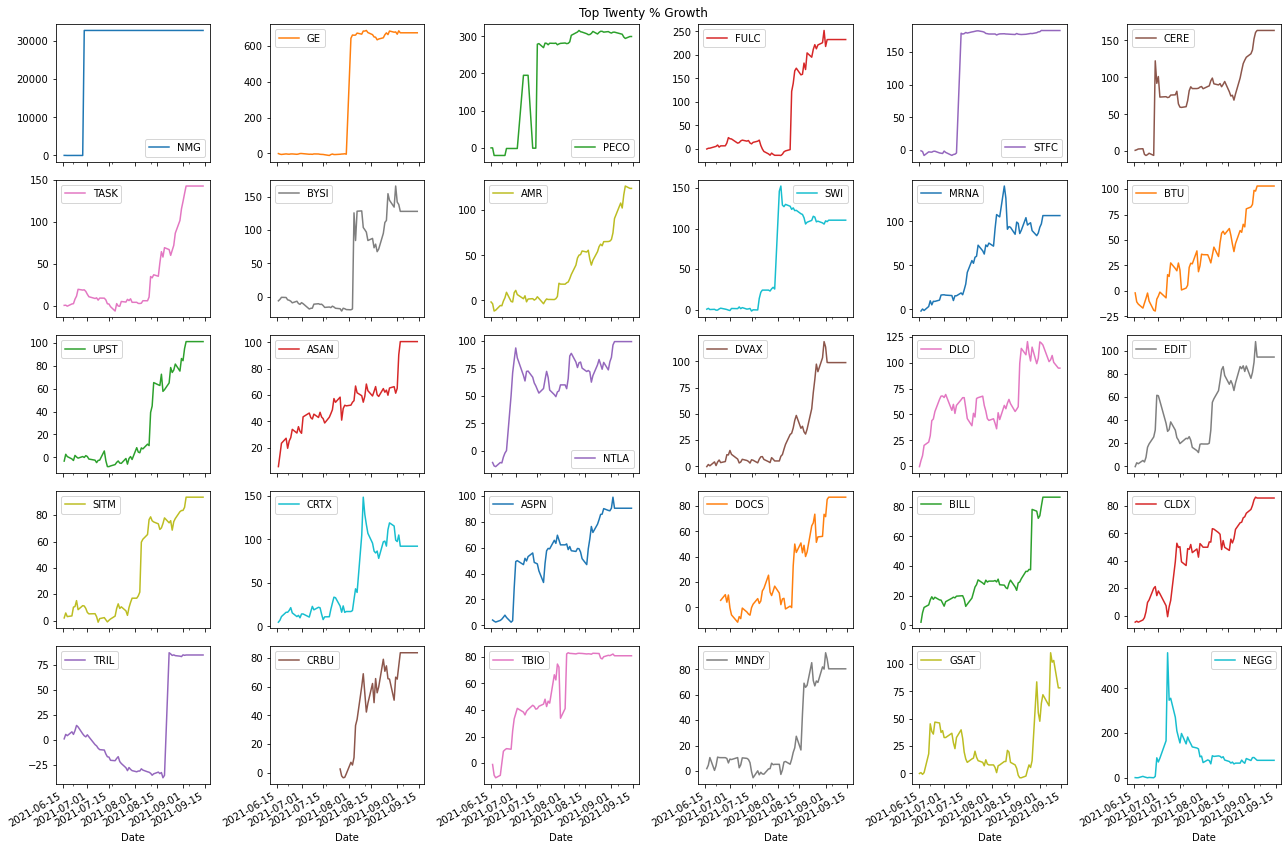

In [ ]:
data_cum_returns[list(topten.index)].mul(100).plot(subplots=True, 
                                          layout=(5, 6), 
                                          figsize=(18,12),
                                          title='Top Twenty % Growth')
plt.tight_layout()
plt.show()

In [ ]:
info_df.drop(['NMG', 'GE', 'STFC', 'BYSI','SWI','PECO'], axis=0, inplace=True)

In [ ]:
info_df.sort_values(by=['Growth'], ascending=False)

,zip,sector,longBusinessSummary,city,phone,state,country,companyOfficers,website,maxAge,...,dayHigh,regularMarketPrice,logo_url,fullTimeEmployees,lastDividendDate,impliedSharesOutstanding,toCurrency,fax,trailingPE,Growth
FULC,02139,Healthcare,"Fulcrum Therapeutics, Inc., a clinical-stage b...",Cambridge,617 651 8851,MA,United States,[],http://www.fulcrumtx.com,1,...,27.4531,26.30,https://logo.clearbit.com/fulcrumtx.com,73.0,NaN,NaN,NaN,NaN,NaN,232.58
CERE,02141,Healthcare,"Cerevel Therapeutics Holdings, Inc., a clinica...",Cambridge,844 304 2048,MA,United States,[],http://www.cerevel.com,1,...,36.6100,34.66,https://logo.clearbit.com/cerevel.com,148.0,NaN,NaN,NaN,NaN,NaN,163.60
TASK,78132,Technology,"TaskUs, Inc. provides outsourcing services for...",New Braunfels,888 400 8275,TX,United States,[],http://www.taskus.com,1,...,69.6647,60.59,https://logo.clearbit.com/taskus.com,31500.0,NaN,97290200.0,NaN,NaN,NaN,142.95
AMR,37620,Basic Materials,"Alpha Metallurgical Resources, Inc. operates a...",Bristol,423 573 0300,TN,United States,[],http://www.alphametresources.com,1,...,54.5599,52.89,https://logo.clearbit.com/alphametresources.com,3300.0,NaN,NaN,NaN,NaN,NaN,124.02
MRNA,02139,Healthcare,"Moderna, Inc., a biotechnology company, develo...",Cambridge,617 714 6500,MA,United States,[],http://www.modernatx.com,1,...,448.8099,419.72,https://logo.clearbit.com/modernatx.com,1800.0,NaN,NaN,NaN,617 583 1998,49.588850,106.71
BTU,63101,Energy,Peabody Energy Corporation engages in coal min...,St. Louis,314-342-3400,MO,United States,[],http://www.peabodyenergy.com,1,...,19.4400,17.53,https://logo.clearbit.com/peabodyenergy.com,4600.0,NaN,NaN,NaN,NaN,NaN,103.01
UPST,94403,Financial Services,"Upstart Holdings, Inc. operates a cloud- based...",San Mateo,650 204 1000,CA,United States,[],http://www.upstart.com,1,...,280.0000,278.00,https://logo.clearbit.com/upstart.com,554.0,NaN,NaN,NaN,NaN,302.502720,101.00
ASAN,94103,Technology,"Asana, Inc., together with its subsidiaries, o...",San Francisco,415 525 3888,CA,United States,[],http://asana.com,1,...,107.1000,101.45,https://logo.clearbit.com/asana.com,1080.0,NaN,183900992.0,NaN,NaN,NaN,100.45
NTLA,02139,Healthcare,"Intellia Therapeutics, Inc., a genome editing ...",Cambridge,857 285 6200,MA,United States,[],http://www.intelliatx.com,1,...,162.4400,154.32,https://logo.clearbit.com/intelliatx.com,312.0,NaN,NaN,NaN,NaN,NaN,99.41
DVAX,94608,Healthcare,"Dynavax Technologies Corporation, a biopharmac...",EmeryVille,510 848 5100,CA,United States,[],http://www.dynavax.com,1,...,15.6602,14.74,https://logo.clearbit.com/dynavax.com,245.0,NaN,NaN,NaN,510 848 1327,NaN,98.88


In [ ]:
info_df.to_csv('growth_shares_info.csv')

References  
https://towardsdatascience.com/read-data-from-google-sheets-into-pandas-without-the-google-sheets-api-5c468536550    
https://stackoverflow.com/questions/32400867/pandas-read-csv-from-url  
